In [19]:
###### training code---copy it here
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import DataLoader 
from torchvision import transforms as T
from torchvision.utils import make_grid
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import wandb
import math
import argparse
import datetime
from time import time

################ data loading ################

def itr_merge(itrs):
    for itr in itrs:
        for v in enumerate(itr):
            yield v

def get_many_forecasting_dataloader(list_loc, time_lag, lo_size, hi_size, batch_size, train_test_split, subsampling_ratio = None):
    """
    get forecasting dataloader for 2D Stochastic NSE

    Parameters
    ----------
    list_loc: list of locations of data files, of dim num_trajectory*num_snapshots*res*res
    time_lag: creat forecasting data with time_lag 
        (i.e. x_t = data[:,:-time_lag,...] and x_{t+tau}=data[:,time_lag:,...])
    lo_size, hi_size: resolutions of x_t and x_{t+tau}
    batch_size: batch size
    train_test_split: a ratio representing the splitting of training/testing data
    subsampling_ratio: used for subsampling a small portion of data, for convenient small scale experiments
    """

    avg_pixel_norm = 3.0679163932800293 # avg data norm computed a priori
    
    print(f'[prepare dataset] time lag {time_lag}')
    
    list_len = len(list_loc)
    list_train_loaders = []
    list_test_loaders = []
    
    for i in range(list_len):
        print(f'---- [data set loc {i}] {list_loc[i]}')
        data_raw,time_raw = torch.load(list_loc[i])
        Ntj, Nts, Nx, Ny = data_raw.size() 
        tmp = torch.norm(data_raw,dim=(2,3),p='fro').mean() / np.sqrt(Nx*Ny)
        print(f'---- [dataset] average pixel norm of data set {tmp.item()}')
        data_raw = data_raw/avg_pixel_norm
        
        if time_lag > 0:
            data_pre = data_raw[:,:-time_lag,...]
            data_post = data_raw[:,time_lag:,...]
        else:
            data_pre = data_raw
            data_post = data_raw

        print(f'---- [processing] low resolution {lo_size}, high resolution {hi_size}')
        hi = torch.nn.functional.interpolate(data_post, size=(hi_size,hi_size),mode='bilinear').reshape([-1,hi_size,hi_size])
        lo = torch.nn.functional.interpolate(data_pre, size=(lo_size,lo_size),mode='bilinear')
        m = nn.Upsample(scale_factor=int(hi_size/lo_size), mode='nearest')
        lo = m(lo).reshape([-1,hi_size,hi_size])
        hi = hi[:,None,:,:] # make the data N C H W
        lo = lo[:,None,:,:] 
        
        if subsampling_ratio:
            hi = hi[:int(subsampling_ratio*hi.size()[0]),...]
            lo = lo[:int(subsampling_ratio*lo.size()[0]),...]
        
        num_train = int(lo.size()[0]*train_test_split)
        print(f'---- [processing] train_test_split {train_test_split}, num of training {num_train}, testing {lo.size()[0]-num_train}')

        train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(lo[:num_train,...],hi[:num_train,...]), batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(lo[num_train:,...],hi[num_train:,...]), batch_size=batch_size, shuffle=False)
        
        list_train_loaders.append(train_loader)
        list_test_loaders.append(test_loader)
        del data_raw
    
    new_avg_pixel_norm = 1.0
    
    return list_train_loaders, list_test_loaders, avg_pixel_norm, new_avg_pixel_norm


################ network ################

from unet import Unet
class Velocity(nn.Module):
    """ 
    This is a wrapper around any architecture
    The warpper handles the additional conditioning input by appending conditioning input as a channel
    """
    def __init__(self, config):
        super(Velocity, self).__init__()
        self.config = config
        self._arch = Unet(
            num_classes = config.num_classes,
            in_channels = config.C + config.cond_channels,
            out_channels= config.C,
            dim = config.unet_channels,
            dim_mults = config.unet_dim_mults,
            resnet_block_groups = config.unet_resnet_block_groups,
            learned_sinusoidal_cond = config.unet_learned_sinusoidal_cond,
            random_fourier_features = config.unet_random_fourier_features,
            learned_sinusoidal_dim = config.unet_learned_sinusoidal_dim,
            attn_dim_head = config.unet_attn_dim_head,
            attn_heads = config.unet_attn_heads,
            use_classes = config.unet_use_classes,
        )
        num_params = np.sum([int(np.prod(p.shape)) for p in self._arch.parameters()])
        print("[Network] Num params in main arch for velocity is", f"{num_params:,}")

    def forward(self, zt, t, y, cond=None):
        inputs = zt
        if cond is not None:
            """appending conditioning input as a channel""" 
            inputs = torch.cat([inputs, cond], dim=1)
        if not self.config.unet_use_classes:
            y = None
        out = self._arch(inputs, t, y)
        return out

################ interpolants and sampler ################

class Interpolants:
    
    """ 
    Definition of interpolants
    I_t = alpha x_0 + beta x_1 (x_0 is Gaussian base)
    R_t = alpha_dot x_0 + beta_dot x_1
    """
    
    def __init__(self, config):
        super(Interpolants, self).__init__()
        self.config = config
        print(f'[Interpolants] noise strength is {config.noise_strength}, multiplied with avg_pixel_norm {config.avg_pixel_norm}')
        
    def alpha(self, t):
        return 1-t

    def alpha_dot(self, t):
        return -1.0 * torch.ones_like(t)

    def beta(self, t):
        return t

    def beta_dot(self, t):
        return 1.0 * torch.ones_like(t)
    
    def wide(self, x):
        return x[:, None, None, None]

    def It(self, D):
        """
        D is a dictionary containing 
        x0 = z0, 
        x1 = z1, 
        zt = I_t = alpha x_0 + beta x_1
        """
        z0 = D['z0']
        z1 = D['z1']
        t = D['t']

        aterm = self.wide(self.alpha(t)) * z0
        bterm = self.wide(self.beta(t)) * z1

        D['zt'] = aterm + bterm
        return D

    def Rt(self, D):
        """
        D is a dictionary containing 
        x0 = z0, 
        x1 = z1, 
        R_t = alpha_dot x_0 + beta_dot x_1
        """
        z0 = D['z0']
        z1 = D['z1']
        t = D['t']

        adot = self.wide(self.alpha_dot(t))
        bdot = self.wide(self.beta_dot(t))
        return (adot * z0) + (bdot * z1)

    

class Sampler:
    """
    sampler 
    self.interpolant: get information from the defined interpolants
    self.logger: information for uploading results to wandb, used in self.log_wandb_figure
    self.EM: EM for sampling
    """
    def __init__(self, config):
        self.config = config
        self.logger = Loggers(config)
        self.interpolant = Interpolants(config)
        return
    
    def wide(self, x):
        return x[:, None, None, None]

    def EM(self, D, model, steps = 200):  # here it is EM, for improved performance, should use odeint
        print('[Sampler] Use EM samplers')
        init_condition = D['z0']
        tgrid = torch.linspace(self.config.t_min_sample, self.config.t_max_sample, steps).type_as(init_condition)
        dt = tgrid[1] - tgrid[0]
        zt = D['z0']
        y = D['y']
        cond = D['cond']
        ones = torch.ones(zt.shape[0]).type_as(zt)
        for tscalar in tgrid:
            t_arr = tscalar * ones
            f = model(zt, t_arr, y, cond = cond) # note we condiition on init cond
            zt_mean = zt + f * dt
            zt = zt_mean
        return zt_mean

    def odeint(self, D, model):
        print('[Sampler] Use odeint samplers')
        return self.pflow(
            b = model,
            z0 = D['z0'],
            y = D['y'],
            cond = D['cond'],
            T_min = self.config.t_min_sample,
            T_max = self.config.t_max_sample,
            steps = 3, # this is just a placeholder, dopri5 is adaptive and doesn't look at steps arg.
            method = 'dopri5',
            return_last = True,
        )
        
    # for plotting samples
    def to_grid(self, x, normalize):
        nrow = 1
        if normalize:
            kwargs = {'normalize' : True, 'value_range' : (-1, 1)}
        else:
            kwargs = {}
        return make_grid(x, nrow = nrow, **kwargs)

    # for logging sampled images to wandb
    def log_wandb_figure(self, sample, D, global_step):
        """
        plot conditioning input, x0, sampled x1, truth x1
        here D includes conditioning input, x0, truth x1
        and sample includes sampled x1
        finally, upload the figures to wandb
        """
        home = self.config.home
        if not os.path.exists(home + "images"):
            os.makedirs(home + "images")
        if self.config.use_wandb:
            def get_tensor_from_figures(tensor_w):
                plt.ioff()
                x = tensor_w.cpu()
                num = x.size()[0]
                for i in range(num):
                    WIDTH_SIZE = 3
                    HEIGHT_SIZE = 3
                    plt.ioff()
                    fig = plt.figure(figsize=(WIDTH_SIZE,HEIGHT_SIZE))
                    plt.imshow(x[i,0,...], cmap=sns.cm.icefire, vmin=-2, vmax=2.)
                    plt.axis('off')
                    plt.savefig(home + f'images/tmp{i}_{self.logger.log_base}.jpg', bbox_inches='tight')
                    plt.close("all") 
                    
                tensor_img = T.ToTensor()(Image.open(home + f'images/tmp1_{self.logger.log_base}.jpg'))
                C, H, W = tensor_img.size()
                final_tensor = torch.zeros((num,C,H,W))
                for i in range(num):
                    tensor_img = T.ToTensor()(Image.open(home + f'images/tmp{i}_{self.logger.log_base}.jpg'))
                    final_tensor[i,...] = tensor_img
                return final_tensor
            
            normalize = False
            
            num_train = config.num_reference_batch_train
            
            sample = get_tensor_from_figures(sample)
            sample_train = self.to_grid(sample[:num_train,...], normalize = normalize)
            sample_test = self.to_grid(sample[num_train:,...], normalize = normalize)
            
            z0 = get_tensor_from_figures(D['z0'])
            z0_train = self.to_grid(z0[:num_train,...], normalize = normalize)
            z0_test = self.to_grid(z0[num_train:,...], normalize = normalize)
            
            z1 = get_tensor_from_figures(D['z1'])
            z1_train = self.to_grid(z1[:num_train,...], normalize = normalize)
            z1_test = self.to_grid(z1[num_train:,...], normalize = normalize)
            
            both_train = torch.cat([z0_train, sample_train, z1_train], dim=-1)
            both_test = torch.cat([z0_test, sample_test, z1_test], dim=-1)
            
            wandb.log({'training-x0_sampledx1_truthx1': wandb.Image(both_train)}, step = global_step)
            wandb.log({'testing-x0_sampledx1_truthx1': wandb.Image(both_test)}, step = global_step)

    @torch.no_grad()
    def sample(self, D, model, global_step, wand_log = True):
        model.eval()
        if self.config.model_type == 'sde':
            zT = self.EM(D, model)
        else:
            assert False
        if self.config.use_wandb and wand_log:
            self.log_wandb_figure(zT, D, global_step)        


################ trainer ################

class Trainer:
    """
    Trainer
    self.prepare_dataset: create dataloaders using provided locations of data files
    self.time_dist: used for sampling time during training
    self.set_reference_batch: randomly picking a small training set and testing set, and test on them on the fly
    """
    def __init__(self, config):
        super(Trainer, self).__init__()
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.prepare_dataset(subsampling_ratio = config.data_subsampling_ratio)
        self.interpolant = Interpolants(self.config)
        self.model = Velocity(self.config)
        self.model.to(self.device)
        self.optimizer = self.get_optimizer(config)
        self.sampler = Sampler(config)
        self.time_dist = torch.distributions.Uniform(low=self.config.t_min_train, high=self.config.t_max_train)
        self.current_epoch = 0
        self.global_step = 0
        self.set_reference_batch(num_train = config.num_reference_batch_train, num_test = config.num_reference_batch_test) # for efficient test
        self.EMsteps = config.EMsteps
        self.home = config.home
        print(f'[save_loc] will save all checkpoints and results to location to {self.home}')

        self.spectrum_amplitude = torch.load("./enstrohpy_spectrum_amplitude.pt")[None,...].cuda()/5 # 1*1*128*128
        self.scalar_amplitude = 0.0
        print('[noise] use noise that has a similar Fourier spectrum as the vorticity field')
        
    def prepare_dataset(self, subsampling_ratio = None):
        self.list_train_loaders, self.list_test_loaders, self.original_avg_pixel_norm, self.avg_pixel_norm = get_many_forecasting_dataloader(self.config.list_data_loc, self.config.time_lag, self.config.lo_size, self.config.hi_size, self.config.batch_size, self.config.train_test_split, subsampling_ratio)
        self.config.avg_pixel_norm = self.avg_pixel_norm
        self.config.original_avg_pixel_norm = self.original_avg_pixel_norm
        
    def set_reference_batch(self, num_train = 10, num_test = 10):
        xlo_train,xhi_train = next(iter(self.list_train_loaders[0]))
        xlo_test,xhi_test = next(iter(self.list_test_loaders[0]))
        self.ref_xlo = torch.cat((xlo_train[0:num_train,...],xlo_test[0:num_train,...]),0)
        self.ref_xhi = torch.cat((xhi_train[0:num_test,...],xhi_test[0:num_test,...]),0)
    
    @torch.no_grad()
    def prepare_batch(self, batch, time = 'unif', use_reference_batch = False):
        """
        D: a dictionary of x0, x1, and t, for interpolants
        here x0 = Gaussian noise given a spectrum
             x1 = z1
             cond = z0
             t = uniform samples from [0,1]
        """
        
        if use_reference_batch:
            xlo, xhi = self.ref_xlo, self.ref_xhi
        else:
            xlo, xhi = batch
            
        y = torch.zeros(xlo.size()[0]) # dummy variable; we do not use labels
        xlo, xhi, y = xlo.to(self.device), xhi.to(self.device), y.to(self.device)

        noise_real = torch.randn_like(xhi)
        noise_img = torch.randn_like(xhi)

        noise = noise_real + 1j * noise_img
        # tmp = torch.fft.ifftn(self.spectrum_amplitude*noise, dim = (2,3),norm = "forward").real

        tmp = torch.fft.ifftn((self.spectrum_amplitude)*noise, dim = (2,3),norm = "forward").real
        D = {'z0': tmp, 'z1': xhi, 'cond': None, 'y': y}

        if time == 'unif':
            D['t'] = self.time_dist.sample(sample_shape = (xhi.shape[0],)).squeeze().type_as(D['z1'])
        else:
            assert False
        D = self.interpolant.It(D)
        return D
    
    def get_optimizer(self, config):
        if config.optimizer == "AdamW":
            print(f'[Optimizer] set up optimizer as {config.optimizer}')
            self.lr = self.config.base_lr
            return torch.optim.AdamW(self.model.parameters(), lr=self.config.base_lr)
    
    def target_function(self, D):
        if self.config.model_type == 'sde':
            target = self.interpolant.Rt(D)  
        else:
            assert False
        return target
    
    def loss_function(self, D):
        assert self.model.training
        model_out = self.model(D['zt'], D['t'], D['y'], cond = D['cond'])
        target = self.target_function(D)
        loss = (model_out - target).pow(2).sum(-1).sum(-1).sum(-1) # using full squared loss here
        return loss.mean()
    
    def clip_grad_norm(self, model, max_grad_norm = 1e+4):
        return torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = max_grad_norm, norm_type = 2.0, error_if_nonfinite = False)

    def optimizer_one_step(self, max_grad_norm = 1e+4):
        self.clip_grad_norm(self.model, max_grad_norm = max_grad_norm)
        if self.global_step % self.config.print_loss_every == 0:
            grads = [ param.grad.detach().flatten() for param in self.model.parameters() if param.grad is not None]
            norm = torch.cat(grads).norm()
            print(f"[Training] Grad step {self.global_step}. Grad norm:{norm}")
            if self.config.use_wandb:
                wandb.log({"Gradnorm": norm}, step = self.global_step)
        self.optimizer.step()
        self.optimizer.zero_grad(set_to_none=True)
        self.global_step += 1
    
    def adjust_learning_rate(self, optimizer):
        lr = self.lr
        if self.config.cosine_scheduler:
            scale = self.global_step / self.config.max_steps
            lr *= 0.5 * (1. + math.cos(math.pi * scale))
            print(f'[Cosine scheduler] lr is now {lr}')
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    
    def fit(self,):
        time_begin = time()
        print("[Training] starting training")
        self.test_model(first_batch_only = True)
        
        while self.global_step < self.config.max_steps:
            print(f"[Training] starting epoch {self.current_epoch}")
            
            for batch_idx, batch in itr_merge(self.list_train_loaders):
   
                if self.global_step >= self.config.max_steps:
                    break

                self.model.train()
                loss = self.loss_function(D = self.prepare_batch(batch, use_reference_batch = False))
                loss.backward()
                self.optimizer_one_step()     
                if self.global_step % self.config.sample_every == 0:
                    # for monitoring sampling, sampling on reference batch and uploading the results on the fly
                    D = self.prepare_batch(batch = None, use_reference_batch = True)
                    self.sampler.sample(D, self.model, self.global_step)

                if self.global_step % self.config.print_loss_every == 0:
                    total_mins = (time() - time_begin) / 60
                    print(f"[Training] Grad step {self.global_step}. Loss:{loss.item()}, finished in {total_mins:.2f} minutes")
                    if self.config.use_wandb:
                        wandb.log({"loss": loss.item()}, step=self.global_step)
                
                if self.global_step % self.config.save_model_every == 0:
                    self.save_model_checkpoint()
                if self.global_step % self.config.test_every == 0:
                    self.test_model(first_batch_only = True)
                    
            self.current_epoch += 1
            self.adjust_learning_rate(self.optimizer)
    
    #### below are testing functions, during the training processes or after training
    def save_model_checkpoint(self):
        
        if not os.path.exists(self.home + f"checkpoint/{logger.verbose_log_name}"):
            os.makedirs(self.home + f"checkpoint/{logger.verbose_log_name}")
        save_path = self.home + f"checkpoint/{logger.verbose_log_name}/model_step{self.global_step}.pth"
        torch.save(self.model.state_dict(), save_path)
        print(f'[Saving models] saving models to {save_path}')


    def sample_results(self, first_batch_only = True, which = 'test', EMsteps = 200):

        assert which in ['train', 'test']
        if which == 'test':

            loader_list = self.list_test_loaders
            #############################
            print(f'[Test] sampling on test data')
            tot_num = 0
            for batch_idx, batch in itr_merge(loader_list):
                num = batch[0].shape[0]
                tot_num = tot_num + num
                
            if first_batch_only:
                tot_num = self.config.batch_size
            print(f'[Test] in total {tot_num} test data, first batch only = {first_batch_only}')

        else:
            
            loader_list = self.list_train_loaders
            print(f'[Test] sampling on training data, first batch only = {first_batch_only}')
            tot_num = self.config.batch_size


        lo_size = config.lo_size
        hi_size = config.hi_size
        test_truth = torch.zeros(tot_num,1,hi_size,hi_size)
        test_input = torch.zeros_like(test_truth)
        test_result = torch.zeros_like(test_truth)

        self.model.eval()
        time_begin = time()
        cur_idx = 0

        for batch_idx, batch in itr_merge(loader_list):
            if first_batch_only and batch_idx > 0: break
            with torch.no_grad():
                num = batch[0].shape[0]
                D = self.prepare_batch(batch, use_reference_batch = False)
                test_input[cur_idx:cur_idx+num,...] = batch[0]
                test_truth[cur_idx:cur_idx+num,...] = batch[1]
                test_result[cur_idx:cur_idx+num,...] = self.sampler.EM(D, self.model, steps = EMsteps)
                total_mins = (time() - time_begin) / 60
                print(f'batch index {batch_idx}, finished in {total_mins:.2f} minutes')
                cur_idx = cur_idx + num

        inputs = test_input[:cur_idx,...]
        truth = test_truth[:cur_idx,...]
        results =  test_result[:cur_idx,...]
        results = torch.cat([inputs, truth, results], dim = 1) * self.original_avg_pixel_norm
        return results
    
    def plot_spectra(self, results, which = 'test'):
    
        assert which in ['train', 'test']

        # energy spectrum
        if not os.path.exists(self.home + "images"):
            os.makedirs(self.home + "images")
        
        from energy_spectrum_plot import plot_avg_spectra_compare_Forecasting_torch as plot_spectra

        spectrum_save_name = self.home + f"images/{logger.verbose_log_name}_spectrum_test_on_{which}.jpg"
        plot_spectra(results[:,1,...], results[:,2,...], save_name = spectrum_save_name)
        print(f"spectrum plot saved to {spectrum_save_name}")
        
        tensor_img = T.ToTensor()(Image.open(spectrum_save_name))

        f = lambda x: wandb.Image(x)
        if config.use_wandb:
            wandb.log({f'energy spectrum (test on {which} data)': f(tensor_img)}, step = self.global_step) 
    
    def compute_norm(self, results, which = 'test'):
        truth = results[:,1,...]
        forecast = results[:,2,...]
        truth_norm = torch.norm(truth,dim=(1,2),p='fro').mean() / self.config.hi_size
        forecast_norm = torch.norm(forecast,dim=(1,2),p='fro').mean() / self.config.hi_size
        relerr = abs(truth_norm-forecast_norm)/truth_norm
        print(f"[testing norms] on {which} data, truth norm is {truth_norm}, forecast norm is {forecast_norm}, relative err {relerr}")
        if self.config.use_wandb:
            wandb.log({f"norm err (on {which} data)":  relerr}, step = self.global_step)
    
    def test_model(self, first_batch_only = True):

        train_results = self.sample_results(first_batch_only = first_batch_only, which = 'train', EMsteps = self.EMsteps)
        test_results = self.sample_results(first_batch_only = first_batch_only, which = 'test', EMsteps = self.EMsteps)

        # norm test
        self.compute_norm(train_results, which = 'train')
        self.compute_norm(test_results, which = 'test')
        
        # spectrum test
        self.plot_spectra(train_results, which = 'train')
        self.plot_spectra(test_results, which = 'test')       

################ logger ################

class Loggers:
    """
    self.log_base: date string for naming of logging files
    self.log_name: detailed information of the experiment, used for naming of logging files
    self.verbose_log_name: more verbose version for naming
    """
    def __init__(self, config):
        date = str(datetime.datetime.now())
        self.log_base = date[date.find("-"):date.rfind(".")].replace("-", "").replace(":", "").replace(" ", "_")
        self.log_name = 'lag' + str(config.time_lag) + 'noise' + str(config.noise_strength) + 'lo' + str(config.lo_size) + 'hi' + str(config.hi_size) + '_' + self.log_base
        self.verbose_log_name = 'uncond_GaussODEspectrumnoise_numdata'+ str(config.num_dataset) + 'noise' + str(config.noise_strength) + 'lo' + str(config.lo_size) + 'hi' + str(config.hi_size) + 'sz' + str(config.base_lr).replace(".","") + 'max' + str(config.max_steps) + '_' + self.log_base
        
    def is_type_for_logging(self, x):
        if isinstance(x, int):
            return True
        elif isinstance(x, float):
            return True
        elif isinstance(x, bool):
            return True
        elif isinstance(x, str):
            return True
        elif isinstance(x, list):
            return True
        elif isinstance(x, set):
            return True
        else:
            return False

    def setup_wandb(self, config):
        if config.use_wandb:
            config.wandb_run = wandb.init(
                    project=config.wandb_project,
                    entity=config.wandb_entity,
                    resume=None,
                    id    =None,
                    name = self.verbose_log_name,
            )
            wandb.run.log_code(".")

            for key in vars(config):
                item = getattr(config, key)
                if self.is_type_for_logging(item):
                    setattr(wandb.config, key, item)
                    print(f'[Config] {key}: {item}')
            print("[wandb] finished wandb setup")
        else:
            print("[wandb] not using wandb setup")

################ config ################


class Config:
    def __init__(self,list_data_loc, home = "./"):
        
        # use wandb for logging
        self.use_wandb = True
        self.wandb_project = 'interpolants_forecasting_new'
        self.wandb_entity = 'yifanc96'

        self.home = home # for storing checkpoints
        
        # data
        self.list_data_loc = list_data_loc
        self.num_dataset = len(list_data_loc)
        self.C = 1
        self.num_classes = 1
        self.lo_size = 128
        self.hi_size = 128
        self.batch_size = 100
        self.num_workers = 4
        self.train_test_split = 0.9
        self.noise_strength = 0.0
        self.data_subsampling_ratio = 1.0  # use a small amount of data, for sanity check of the code
        
        # training
        self.optimizer = 'AdamW'
        self.cosine_scheduler = True
        self.model_type = 'sde'
        self.base_lr = 2*1e-4
        self.max_steps = 100
        self.t_min_train = 0
        self.t_max_train = 1
        self.t_min_sample = 0
        self.t_max_sample = 1
        self.EMsteps = 200
        self.print_loss_every = 20 
        self.print_gradnorm_every =  20
        self.num_reference_batch_train = 10
        self.num_reference_batch_test = 10
        self.sample_every = 200 # sampling on reference batch every # iterations
        self.test_every = 200 # test energy spectrum and norm on reference batch every # iterations
        self.save_model_every = 2000 # save model checkpoints every # iterations
        
        # architecture
        self.unet_use_classes = False
        self.model_size = 'medium'
        if self.model_size == 'small':
            self.unet_channels = 8
            self.unet_dim_mults = (1, 1, 1, 1)
            self.unet_resnet_block_groups = 8
            self.unet_learned_sinusoidal_dim = 8
            self.unet_attn_dim_head = 8
            self.unet_attn_heads = 1
            self.unet_learned_sinusoidal_cond = False
            self.unet_random_fourier_features = False
        
        elif self.model_size == 'medium':
            self.unet_channels = 32
            self.unet_dim_mults = (1, 2, 2, 2)
            self.unet_resnet_block_groups = 8
            self.unet_learned_sinusoidal_dim = 32
            self.unet_attn_dim_head = 32
            self.unet_attn_heads = 4
            self.unet_learned_sinusoidal_cond = True
            self.unet_random_fourier_features = False
   
        elif self.model_size == 'large':
            self.unet_channels = 128
            self.unet_dim_mults = (1, 2, 2, 2)
            self.unet_resnet_block_groups = 8
            self.unet_learned_sinusoidal_dim = 32
            self.unet_attn_dim_head = 64
            self.unet_attn_heads = 4
            self.unet_learned_sinusoidal_cond = True
            self.unet_random_fourier_features = False
        else:
            assert False
        self.cond_channels = 0  # dimension of the conditional channel; here conditioned on z_0
        # the conditioned term is appended to the input (so the final channel dim = cond_channels + input_channels)

def get_parser():
    parser = argparse.ArgumentParser(description='PyTorch framework for stochastic interpolants')
    parser.add_argument("--data_subsampling_ratio", type=float, default=1.0)
    parser.add_argument("--batch_size", type=int, default=100)
    parser.add_argument("--noise_strength", type=float, default=0.0) #for Gaussian base, no noise added
    parser.add_argument("--base_lr", type=float, default=2e-4)
    parser.add_argument("--lo_size", type=int, default=128)
    parser.add_argument("--hi_size", type=int, default=128)
    parser.add_argument("--time_lag", type=int, default=2)
    parser.add_argument("--max_steps", type=int, default=50000)
    parser.add_argument("--sample_every", type=int, default=1000)
    parser.add_argument("--test_every", type=int, default=1000)
    parser.add_argument("--save_model_every", type=int, default=2000)
    parser.add_argument("--num_dataset",type=int,default=1)
    parser.add_argument('--use_wandb', type = int, default = 0) # 1 is use_wandb, and 0 is not use_wandb
    args = parser.parse_args([])
    return args

random_seed = 0
torch.manual_seed(0)
np.random.seed(random_seed)
args = get_parser()
args.use_wandb = bool(args.use_wandb)


###### data location
# list_data_loc = ["/data_file.pt"]
list_suffix = [f"0{i}" for i in np.arange(1,args.num_dataset+1)]
# list_data_loc = [f"/scratch/mh5113/forecasting/new_simulations_lag_05_term" + i + ".pt" for i in list_suffix]
list_data_loc = [f"/scratch/yc3400/forecasting/NSEdata/data_file" + i + ".pt" for i in list_suffix]
# /scratch/yc3400/forecasting/NSEdata/
if args.num_dataset < len(list_data_loc): 
    list_data_loc = list_data_loc[:args.num_dataset]
    args.num_dataset = len(list_data_loc)

##### checkpoint and image storage location
# home = "./"
home = "/scratch/yc3400/forecasting/" 

config = Config(list_data_loc, home)
for arg in vars(args):
    print(f'[Argparse] change config {arg} to {getattr(args, arg)}')
    setattr(config, arg, getattr(args, arg))
logger = Loggers(config)
logger.setup_wandb(config)
trainer = Trainer(config)


[Argparse] change config data_subsampling_ratio to 1.0
[Argparse] change config batch_size to 100
[Argparse] change config noise_strength to 0.0
[Argparse] change config base_lr to 0.0002
[Argparse] change config lo_size to 128
[Argparse] change config hi_size to 128
[Argparse] change config time_lag to 2
[Argparse] change config max_steps to 50000
[Argparse] change config sample_every to 1000
[Argparse] change config test_every to 1000
[Argparse] change config save_model_every to 2000
[Argparse] change config num_dataset to 1
[Argparse] change config use_wandb to False
[wandb] not using wandb setup
[prepare dataset] time lag 2
---- [data set loc 0] /scratch/yc3400/forecasting/NSEdata/data_file01.pt


/state/partition1/job-63251859/ipykernel_798305/1028052208.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_raw,time_raw = torch.load(list_loc[i])


---- [dataset] average pixel norm of data set 3.072007417678833
---- [processing] low resolution 128, high resolution 128
---- [processing] train_test_split 0.9, num of training 17640, testing 1960
[Interpolants] noise strength is 0.0, multiplied with avg_pixel_norm 1.0
NOT USING CLASSES IN UNET
[Network] Num params in main arch for velocity is 2,062,289
[Optimizer] set up optimizer as AdamW
[Interpolants] noise strength is 0.0, multiplied with avg_pixel_norm 1.0
[save_loc] will save all checkpoints and results to location to /scratch/yc3400/forecasting/
[noise] use noise that has a similar Fourier spectrum as the vorticity field


/state/partition1/job-63251859/ipykernel_798305/1028052208.py:342: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.spectrum_amplitude = torch.load("./enstrohpy_spectrum_a

In [20]:
#### get test dataset
hi_size = config.hi_size
z1 = torch.load(list_data_loc[0])[0]
z1 = torch.nn.functional.interpolate(z1, size=(hi_size,hi_size),mode='bilinear')
z1 = z1.reshape(-1,hi_size,hi_size)
avg_pixel_norm = 3.0679163932800293
z1 = z1/avg_pixel_norm

n_data = 200
thisdata = z1[:n_data,None,...]
thisdata_lag = z1[2:n_data+2,None,...]

/state/partition1/job-63251859/ipykernel_798305/1069225257.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z1 = torch.load(list_data_loc[0])[0]


In [26]:
### get checkpoint

## unconditional-spectrum-noise
PATH_file = "/scratch/yc3400/forecasting/checkpoint/uncond_GaussODEspectrumnoise_numdata5noise0.0lo128hi128sz00001max50000_0630_144341/model_step50000.pth"

## unconditional-spectrum-noise-mul-sqrtk
# PATH_file = "/scratch/yc3400/forecasting/checkpoint/ucond_GaussODE_specnoisemulkquarter_numdata5lag2noise0.0lo128hi128sz00001max50000_0630_145639/model_step50000.pth"

## unconditional-spectrum-noise-mul-k
# PATH_file = "/scratch/yc3400/forecasting/checkpoint/uncond_GaussODE_specnoisemulk_numdata5lag2noise0.0lo128hi128sz00001max50000_0630_145639/model_step50000.pth"

## unconditional-white-noise
# PATH_file = "/scratch/yc3400/forecasting/checkpoint/uncond_GaussODE_numdata5noise0.0lo128hi128sz00001max50000_0630_143741/model_step50000.pth"


print(PATH_file)

/scratch/yc3400/forecasting/checkpoint/uncond_GaussODEspectrumnoise_numdata5noise0.0lo128hi128sz00001max50000_0630_144341/model_step50000.pth


In [27]:
import scipy.stats as stats
def get_Fourier_spectrum(data):
    data_hat = torch.fft.fftn(data,dim=(1,2),norm = "forward")
    fourier_amplitudes = np.abs(data_hat)**2
    fourier_amplitudes = fourier_amplitudes.mean(dim=0)
    npix = data_hat.shape[-1]
    kfreq = np.fft.fftfreq(npix) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()
    
    kbins = np.arange(0.5, npix//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins_w, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
    Abins_w *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    
    return kvals, Abins_w

In [28]:
from time import time
time_begin = time()

res_load = torch.load(PATH_file)
trainer.model.load_state_dict(res_load)
trainer.model.eval()

test_input = thisdata.to(trainer.device)
test_truth = thisdata_lag.to(trainer.device)
test_result = torch.zeros(n_data,1,hi_size,hi_size).to(trainer.device)
input_batch = [test_input,test_truth]


####### RK integration

from torchdiffeq import odeint
class PFlowRHS(nn.Module):
    def __init__(self, drift_b, y, cond):
        super(PFlowRHS, self).__init__()
        self.drift_b = drift_b
        self.y = y
        self.cond = cond
        
    def forward(self, t, states):
        (zt,) = states
        t_arr = torch.ones(zt.shape[0]).type_as(zt) * t
        dzt = self.drift_b(zt, t_arr, self.y, cond = self.cond)
        return (dzt,)
             
class PFlowIntegrator:
        
    def __init__(self):
        return        

    def __call__(self, drift_b, z0, y, cond, T_min, T_max, steps, method='dopri5', return_last = True):

        rhs = PFlowRHS(drift_b, y, cond)

        t = torch.linspace(
            T_min, T_max, steps
        ).type_as(z0)

        int_args = {
            'method': method, 
            # 'atol': c.integration_atol, 
            # 'rtol': c.integration_rtol,
        }

        (z,) = odeint(rhs, (z0,), t, **int_args)
        if return_last:
            return z[-1].clone()
        else:
            return z

pflow = PFlowIntegrator()

t_min_sample = 1e-3
t_max_sample = 1-1e-3
drift_b = trainer.model
time_begin = time()

spectrum_amplitude = torch.load("./enstrohpy_spectrum_amplitude.pt")[None,...]/5 # 1*1*128*128
# npix = spectrum_amplitude.shape[-1]
# kfreq = np.fft.fftfreq(npix) * npix
# kfreq2D = np.meshgrid(kfreq, kfreq)
# spectrum_amplitude = spectrum_amplitude * torch.tensor(((np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)))).float()
# spectrum_amplitude = spectrum_amplitude * torch.tensor(np.sqrt(np.sqrt(np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)))).float()
spectrum_amplitude = spectrum_amplitude.cuda()

noise_real = torch.randn_like(test_input)
noise_img = torch.randn_like(test_input)
noise = noise_real + 1j * noise_img
noise = torch.fft.ifftn((spectrum_amplitude)*noise, dim = (2,3),norm = "forward").real

# noise = torch.randn_like(test_input)  # white noise
noise = noise.to(trainer.device)

with torch.no_grad():
    D = trainer.prepare_batch(input_batch)  
    test_input = D['z0']
    test_truth = D['z1']
    D['z0'] = noise
    test_result = pflow(
        drift_b = drift_b,
        z0 = D['z0'],
        y = None,
        cond = D['cond'],
        T_min = t_min_sample,
        T_max = t_max_sample,
        steps = 10, 
        method = 'rk4',
        return_last = True,)
    total_mins = (time() - time_begin) / 60
    print(f'finished in {total_mins:.2f} minutes')

results = torch.cat([noise, test_truth, test_result], dim = 1) 




/state/partition1/job-63251859/ipykernel_798305/2726336597.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_load = torch.load(PATH_file)
/state/partition1/job-6325185

finished in 0.39 minutes


/state/partition1/job-63251859/ipykernel_798305/4276667180.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  fourier_amplitudes = np.abs(data_hat)**2


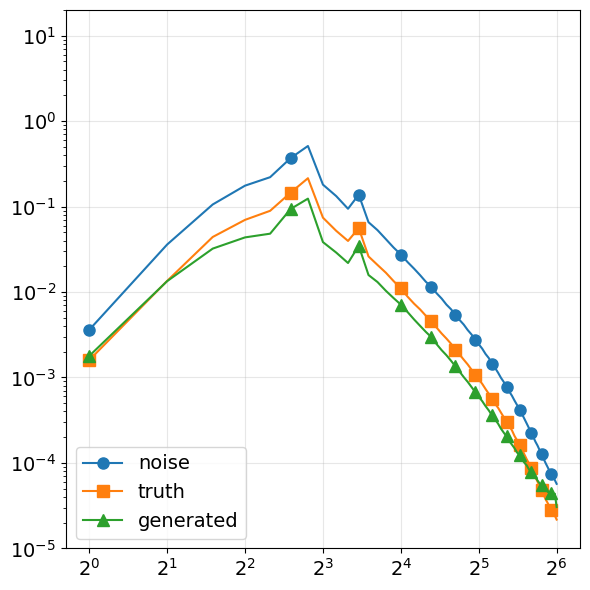

In [29]:
markers = ['o', 's', '^', 'd', 'v']

kvals, Abins_w0 = get_Fourier_spectrum(results[:,0,...].cpu())
kvals, Abins_w1 = get_Fourier_spectrum(results[:,1,...].cpu())
kvals, Abins_w2 = get_Fourier_spectrum(results[:,2,...].cpu())

fig = plt.figure(figsize=(6,6))
plt.plot(kvals, Abins_w0,marker=markers[0], markersize=8, markevery=5, linestyle='-', label = 'noise')
plt.plot(kvals, Abins_w1, marker=markers[1], markersize=8, markevery=5, linestyle='-', label = 'truth')
plt.plot(kvals, Abins_w2, marker=markers[2], markersize=8, markevery=5, linestyle='-', label = 'generated')
plt.legend(fontsize=14, loc='lower left')
plt.grid(alpha=0.3)
plt.xscale('log', base = 2)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)  # Change 14 to your desired size
plt.ylim(1e-5, 2*1e1)

plt.tight_layout()

# fig.savefig('NSE-spectrum-noise-mulk-quarter-RK10.pdf')
# fig.savefig('NSE-spectrum-noise-RK10.pdf')
# fig.savefig('NSE-spectrum-noise-mulk-RK10.pdf')

In [25]:
# torch.save(Abins_w2, "NS-res128-spectrum-noisemulk-generated-RK10.pt")
# torch.save(Abins_w1, "NS-res128-spectrum-noisemulk-truth-RK10.pt")
# torch.save(Abins_w0, "NS-res128-spectrum-noisemulk-noise-RK10.pt")

In [30]:
# torch.save(Abins_w2, "NS-res128-spectrum-noise-generated-RK10.pt")
# torch.save(Abins_w1, "NS-res128-spectrum-noise-truth-RK10.pt")
# torch.save(Abins_w0, "NS-res128-spectrum-noise-noise-RK10.pt")